In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE                    
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("../PreProcessingResumes/processed_data/Resume_removeStopword_useLemm/train.csv")
df.head()

,ID,Resume_str,Category
0,28111403,president chief executive officer executive pr...,INFORMATION-TECHNOLOGY
1,29908929,business development marketing summary busines...,BUSINESS-DEVELOPMENT
2,15261348,chef restaurant manager summary chef year high...,CHEF
3,75435017,charge nurse professional summary objective ob...,HEALTHCARE
4,41152404,test analyst intern contractor profile year pr...,INFORMATION-TECHNOLOGY


In [3]:
# TF-IDF vectorizer that converts a collection of raw text documents into a matrix of TF-IDF features
tfidf_vect = TfidfVectorizer(
    lowercase=True,         # Convert all text to lowercase
    binary=False,           # Use term frequency, not just presence/absence
    max_features=10000,     # Keep only the top 10,000 most frequent terms
    ngram_range=(1, 3),     # Extract n-grams
    max_df=0.8,             # Ignore terms that appear in more than 80% of documents
    min_df=2                # Ignore terms that appear in fewer than 2 documents
)

### Random Forest Classifier

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
class_counts = df['Category'].value_counts()
min_classes = class_counts[class_counts < 0.75*class_counts.mean()].index.tolist()

print(f"Applying SMOTE to classes: {min_classes}")

target_size = int(0.75*class_counts.max())
sampling_strategy = {cls: target_size for cls in min_classes}

Applying SMOTE to classes: ['ADVOCATE', 'APPAREL', 'BPO', 'AGRICULTURE', 'ARTS', 'AUTOMOBILE']


In [6]:
pipeline = Pipeline(steps=[
    ('tfidf', tfidf_vect),
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=4)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [7]:
param_grid = {
    'clf__n_estimators': [400, 700],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__max_depth' : [8, 9, 10],
    'clf__criterion' : ['gini', 'entropy'],
    'clf__min_samples_split': [10],
    'clf__min_samples_leaf': [15]
}

scoring = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring= scoring,
    refit = False,
    return_train_score=True,
    n_jobs=-1
)

start = time()
grid_search = grid.fit(df['Resume_str'], df['Category'])

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.")

GridSearchCV took 380.28 seconds for 24 candidates parameter settings.


In [8]:
# Convert the cross-validation results from GridSearchCV into a pandas DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Sort the results by the weighted F1 score in descending order
results_df = results_df.sort_values(by='mean_test_f1_weighted', ascending=False).reset_index(drop=True)

In [9]:
for i in range(len(results_df)):
    print(f"\n[{i+1}] Params: {results_df['params'][i]}")
    
    for metric in scoring:
        
        print(f"{metric.upper()}:")
        print(f"\tTRAIN:", end='')
        for fold in range(skf.get_n_splits()):
            print(f"\tFold {fold+1}: {results_df[f'split{fold}_train_{metric}'][i]:.4f}", end='')
        print(f"\t\tMean: {results_df[f'mean_train_{metric}'][i]:.4f}", end='')
        print(f"\tStd: {results_df[f'std_train_{metric}'][i]:.4f}")

        print(f"\tTEST:", end='')
        for fold in range(skf.get_n_splits()):
            print(f"\tFold {fold+1}: {results_df[f'split{fold}_test_{metric}'][i]:.4f}", end='')
        print(f"\t\tMean: {results_df[f'mean_test_{metric}'][i]:.4f}", end='')
        print(f"\tStd: {results_df[f'std_test_{metric}'][i]:.4f}\n")


[1] Params: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}
ACCURACY:
	TRAIN:	Fold 1: 0.7317	Fold 2: 0.7288	Fold 3: 0.7294	Fold 4: 0.7325	Fold 5: 0.7237		Mean: 0.7292	Std: 0.0031
	TEST:	Fold 1: 0.6809	Fold 2: 0.6474	Fold 3: 0.6398	Fold 4: 0.6222	Fold 5: 0.6121		Mean: 0.6405	Std: 0.0238

F1_WEIGHTED:
	TRAIN:	Fold 1: 0.6992	Fold 2: 0.7007	Fold 3: 0.7050	Fold 4: 0.7074	Fold 5: 0.6898		Mean: 0.7004	Std: 0.0061
	TEST:	Fold 1: 0.6482	Fold 2: 0.6057	Fold 3: 0.6085	Fold 4: 0.5996	Fold 5: 0.5685		Mean: 0.6061	Std: 0.0254

PRECISION_WEIGHTED:
	TRAIN:	Fold 1: 0.7485	Fold 2: 0.7804	Fold 3: 0.7488	Fold 4: 0.7807	Fold 5: 0.7418		Mean: 0.7600	Std: 0.0169
	TEST:	Fold 1: 0.6544	Fold 2: 0.6519	Fold 3: 0.6491	Fold 4: 0.6612	Fold 5: 0.6670		Mean: 0.6567	Std: 0.0065

RECALL_WEIGHTED:
	TRAIN:	Fold 1: 0.7317	Fold 2: 0.7288	Fold 3: 0.7294	Fold 4: 0.7325	Fold 5: 0.7237		Mean: 0.7292	Std: 0.0031
	

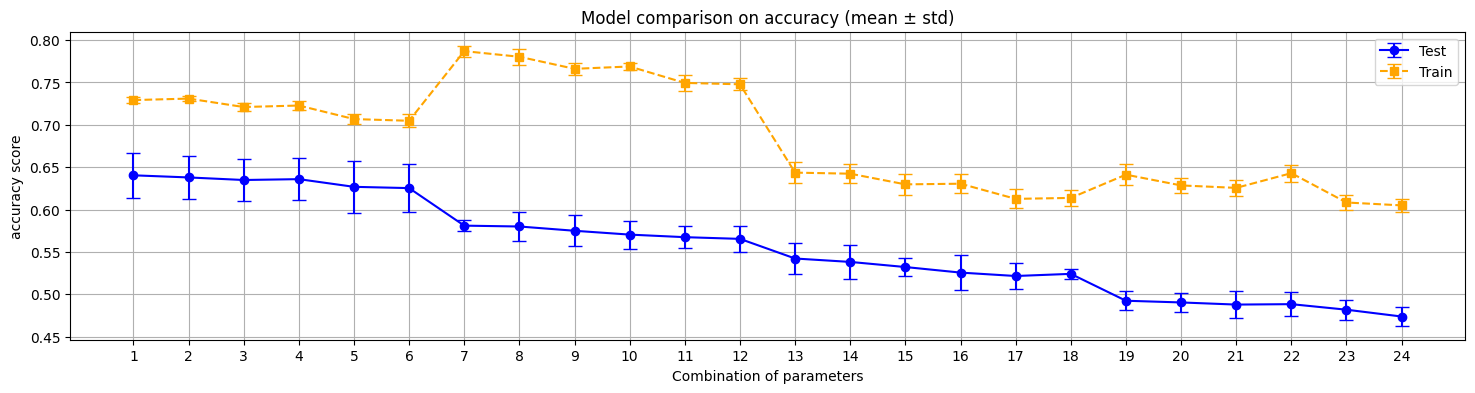

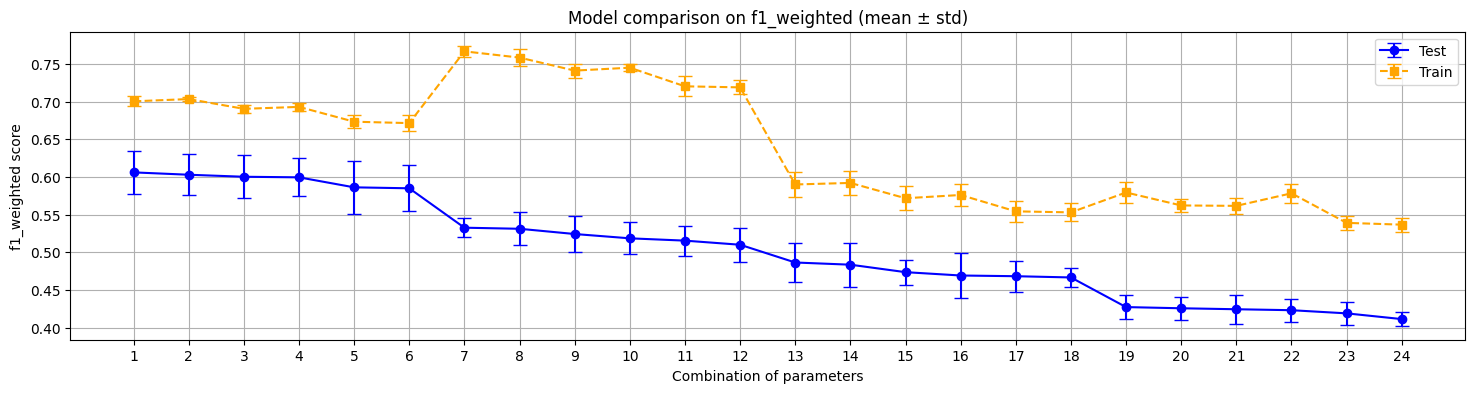

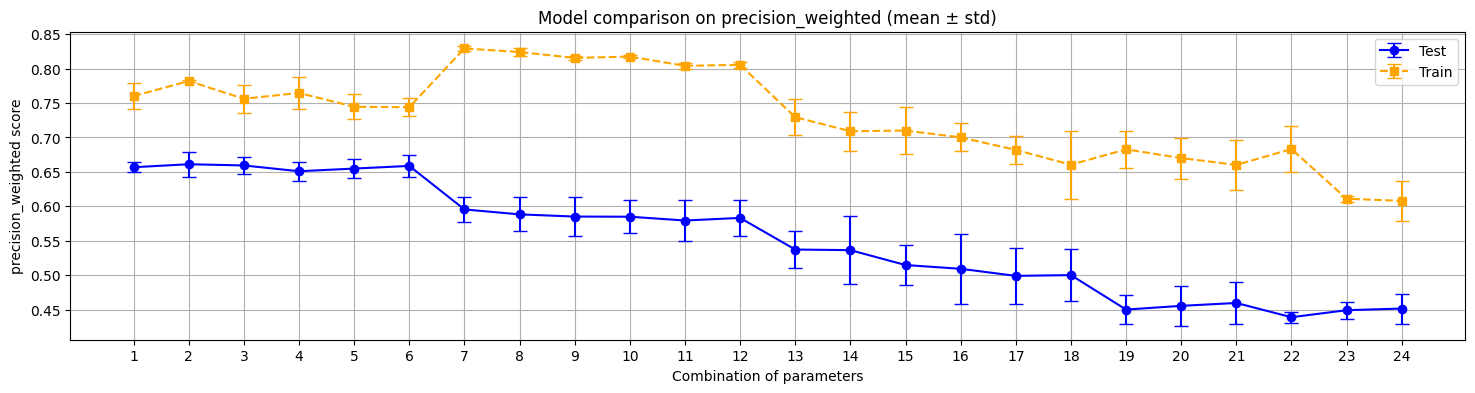

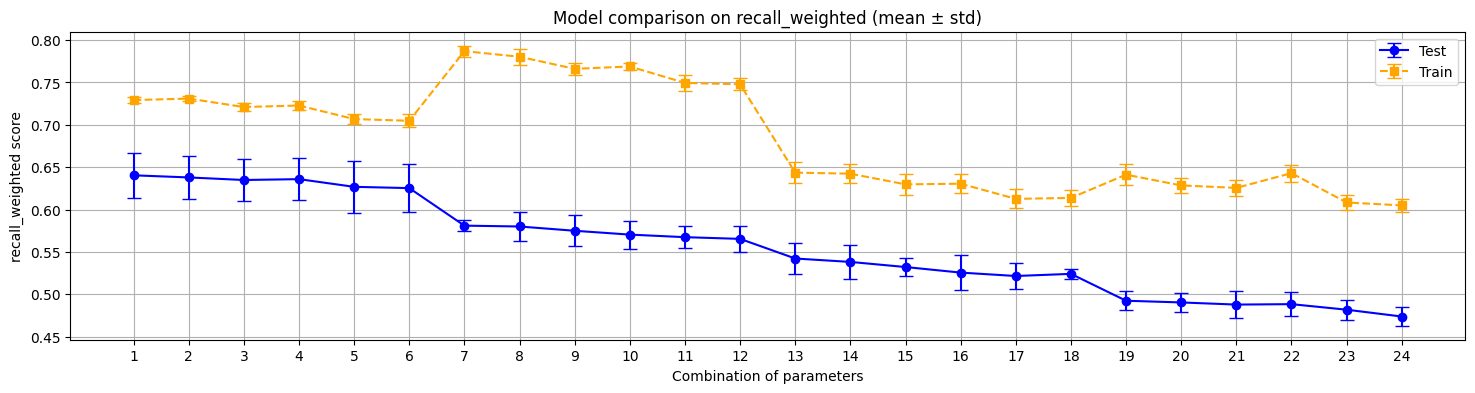

In [10]:
for metric in scoring:
    data_train = {}
    data_test = {}
    for i in range(len(results_df)):
        col_name = f'{i+1}'
        data_test[col_name] = [results_df[f'split{fold}_test_{metric}'][i] for fold in range(skf.get_n_splits())]
        data_train[col_name] = [results_df[f'split{fold}_train_{metric}'][i] for fold in range(skf.get_n_splits())]

    df_train = pd.DataFrame(data_train)
    df_test = pd.DataFrame(data_test)

    means_test = df_test.mean()
    stds_test = df_test.std()
    means_train = df_train.mean()
    stds_train = df_train.std()

    plt.figure(figsize=(max(6, len(results_df) * 0.75), 4))

    plt.errorbar(means_test.index, means_test.values, yerr=stds_test.values, fmt='-o', capsize=5, label='Test', color='blue')

    plt.errorbar(means_train.index, means_train.values, yerr=stds_train.values, fmt='--s', capsize=5, label='Train', color='orange')

    plt.ylabel(f'{metric} score')
    plt.xlabel('Combination of parameters')
    plt.title(f'Model comparison on {metric} (mean ± std)')
    plt.legend()
    plt.grid(True)
    plt.show()

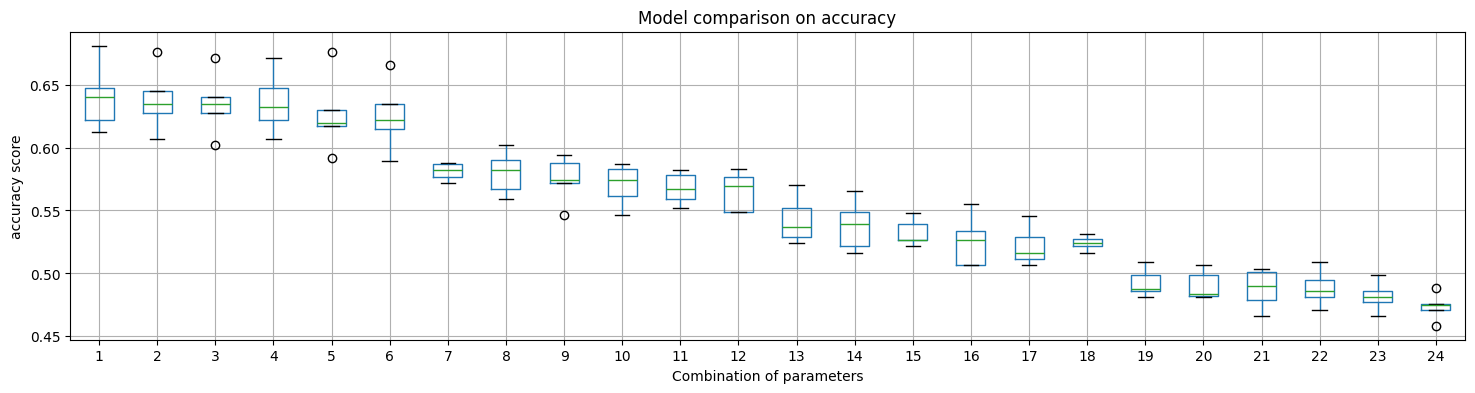

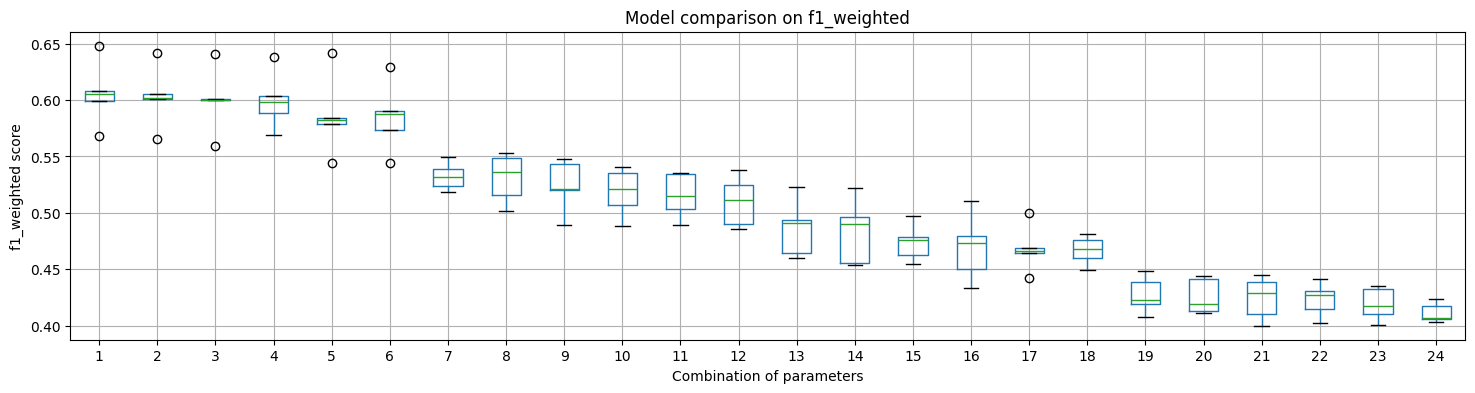

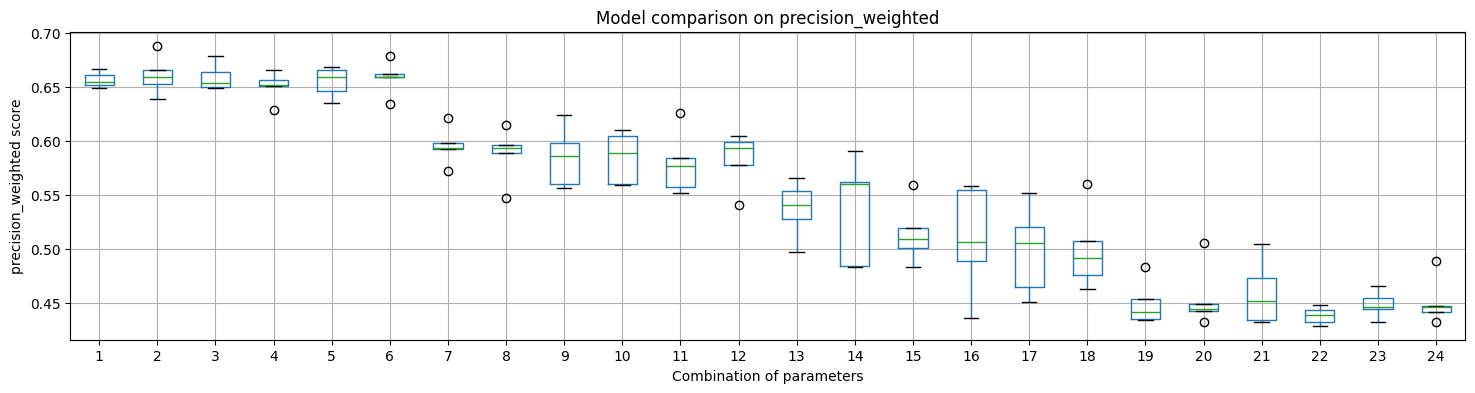

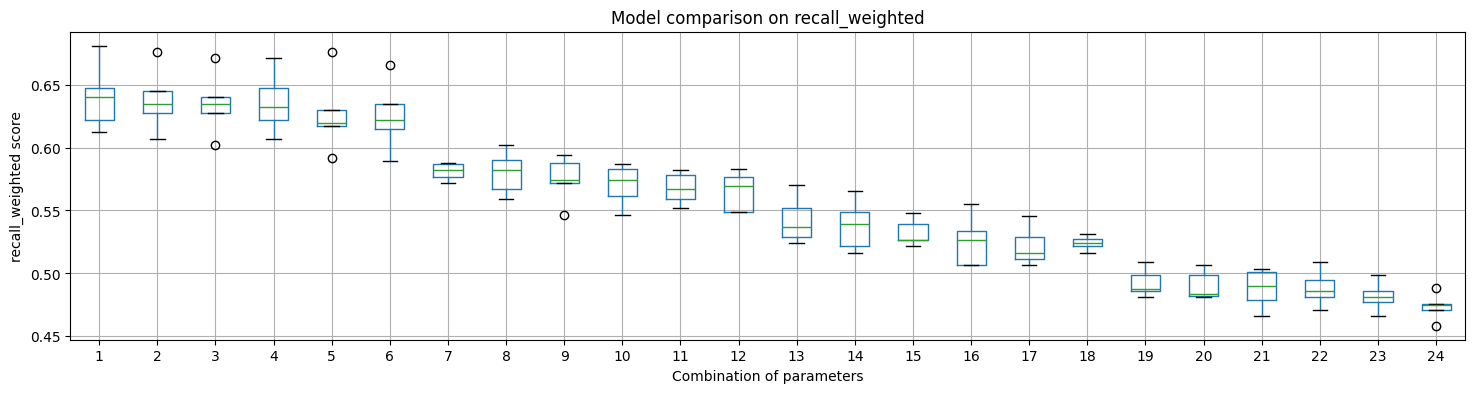

In [11]:
for metric in scoring:
    data = {}
    for i in range(len(results_df)):
        col_name = f'{i+1}'
        data[col_name] = [results_df[f'split{fold}_test_{metric}'][i] for fold in range(skf.get_n_splits())]

    df_metric = pd.DataFrame(data)
    ax = df_metric.boxplot(figsize=(max(6, len(results_df) * 0.75), 4))
    ax.set_ylabel(f'{metric} score')
    ax.set_xlabel('Combination of parameters')
    plt.title(f'Model comparison on {metric}')
    plt.grid(True)
    plt.show()

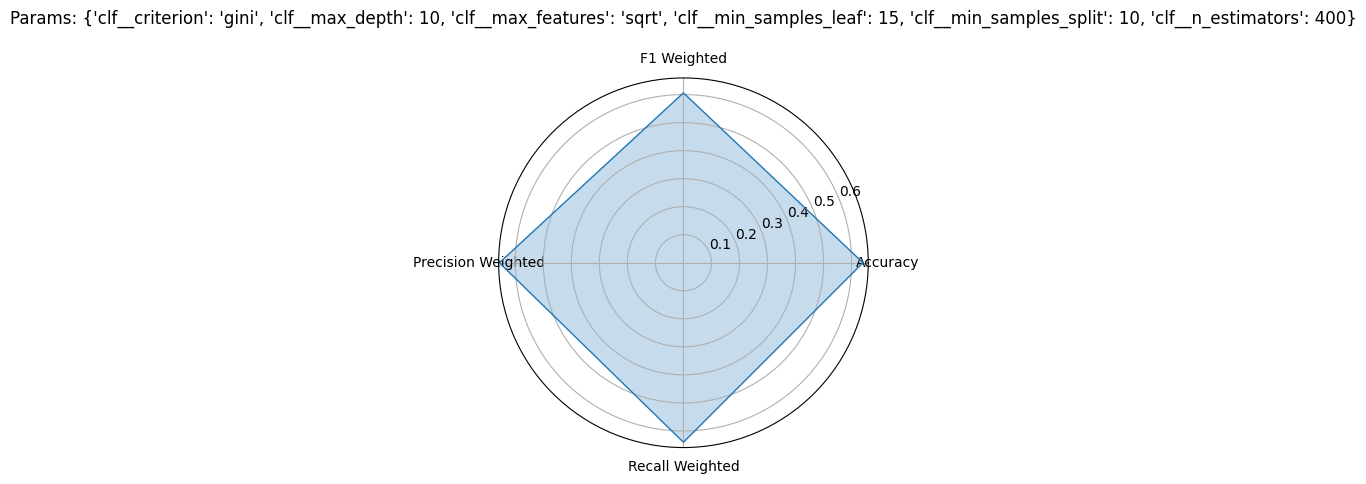

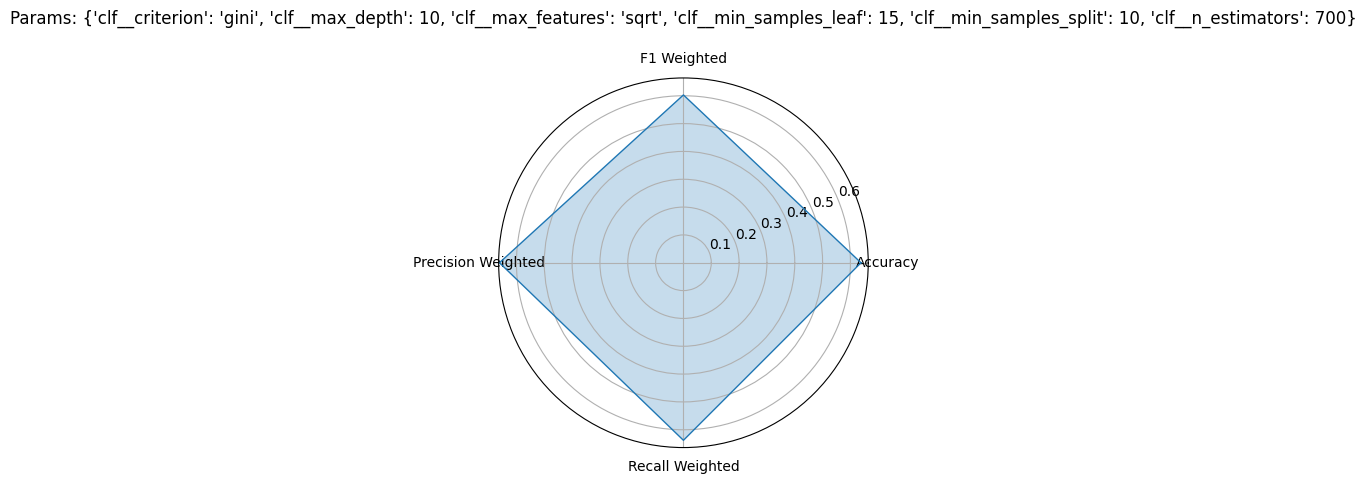

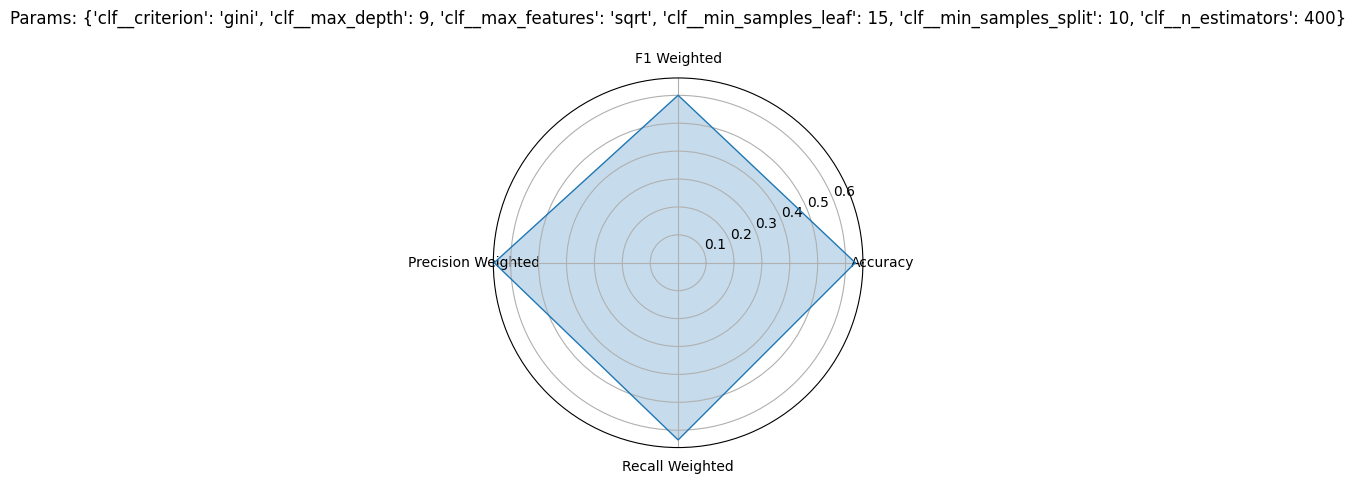

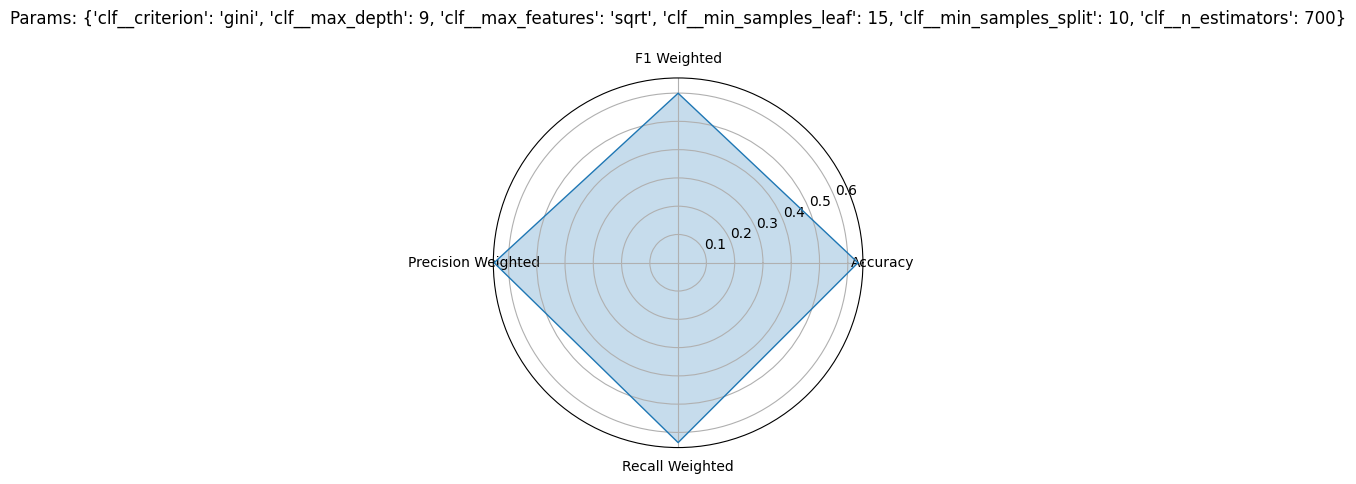

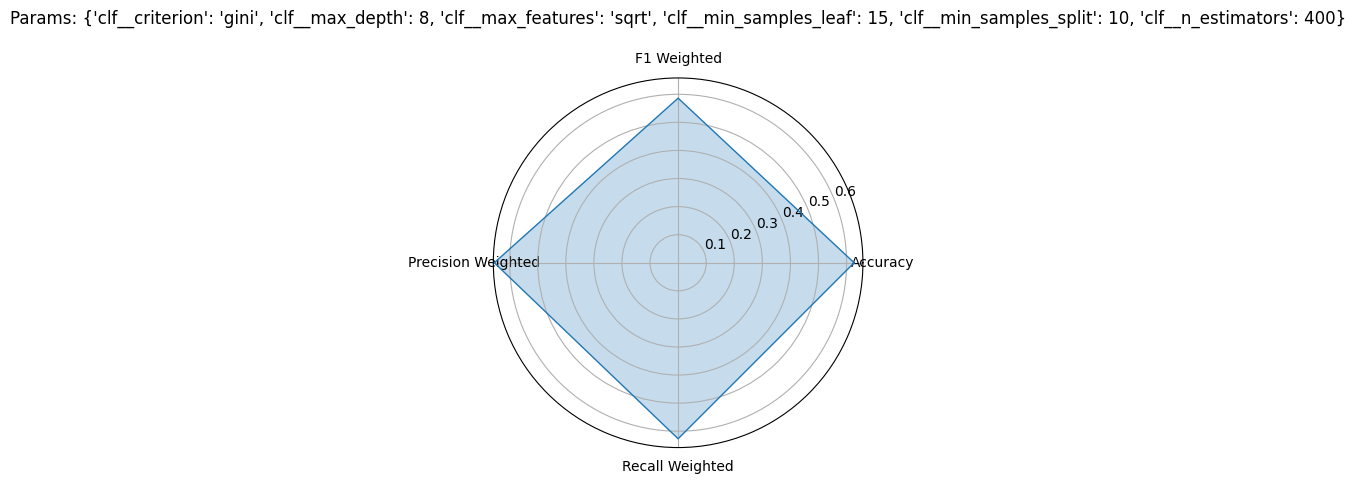

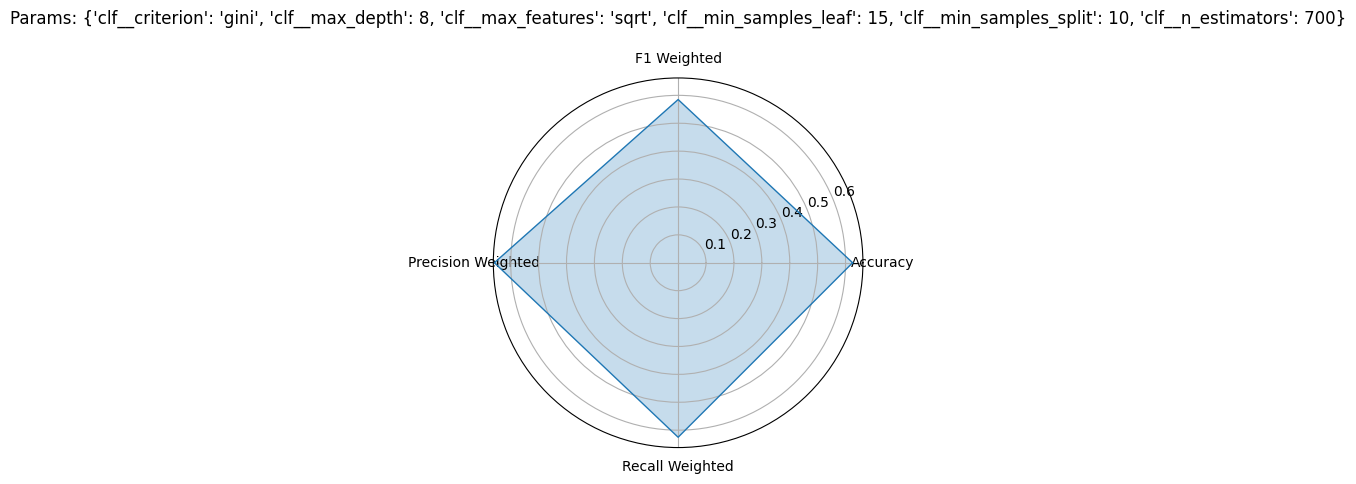

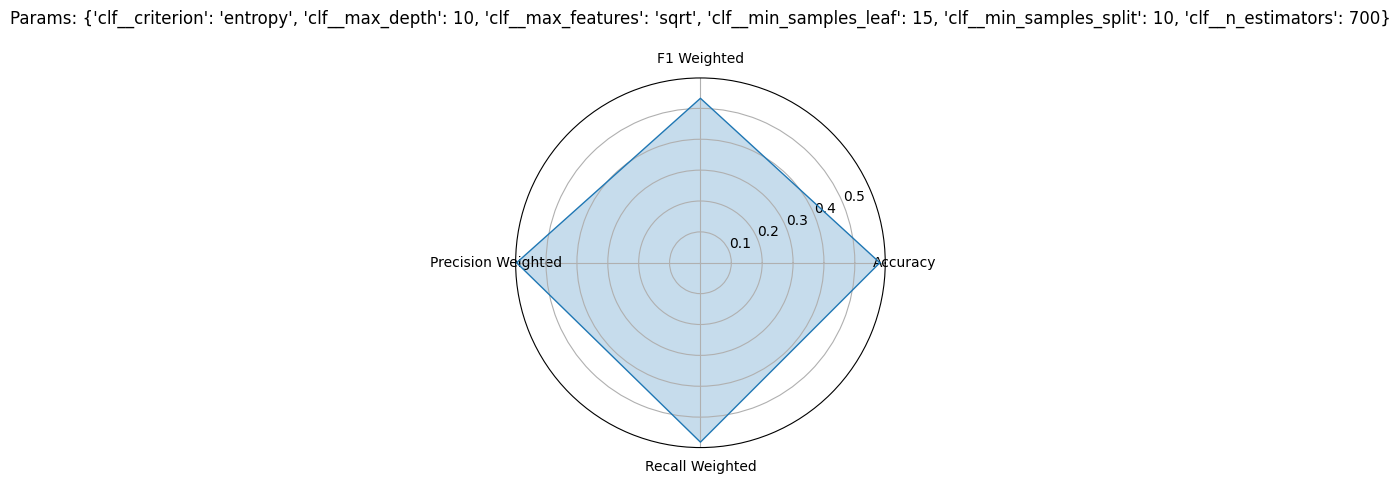

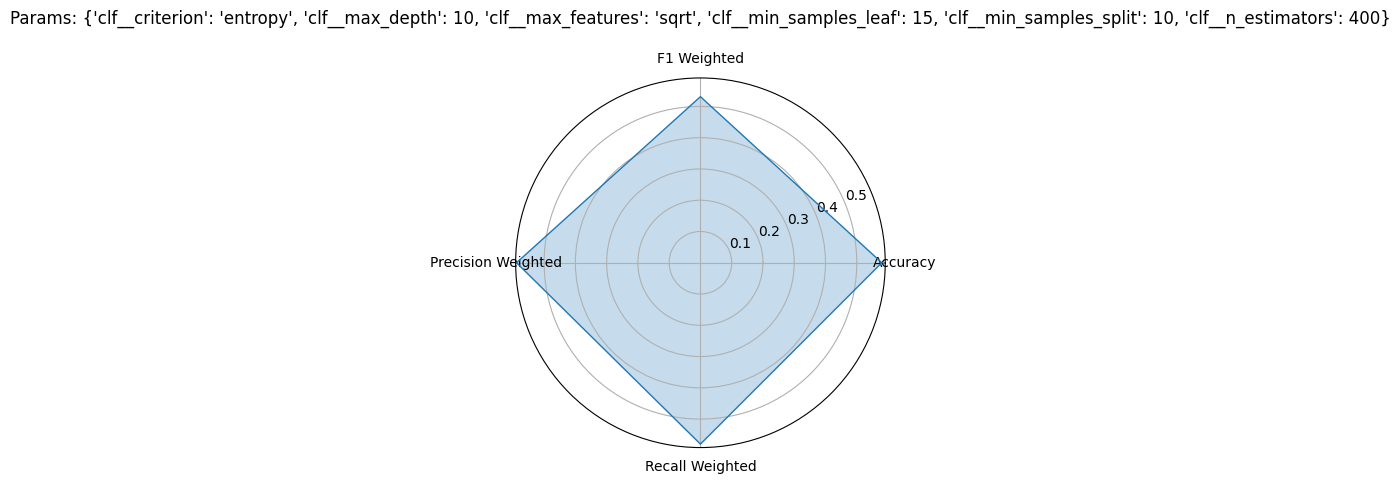

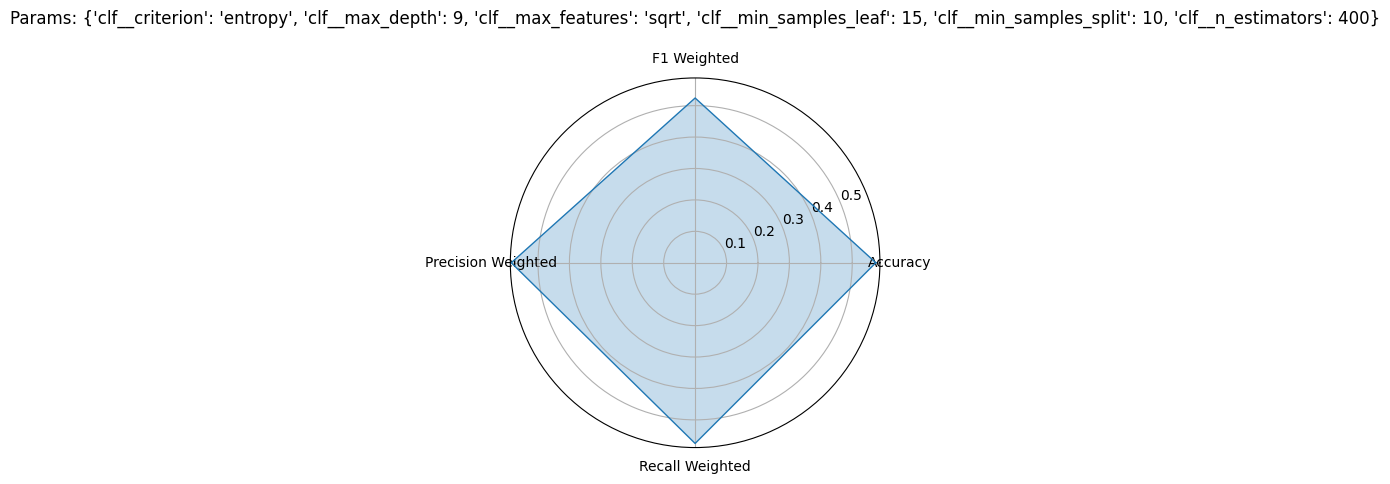

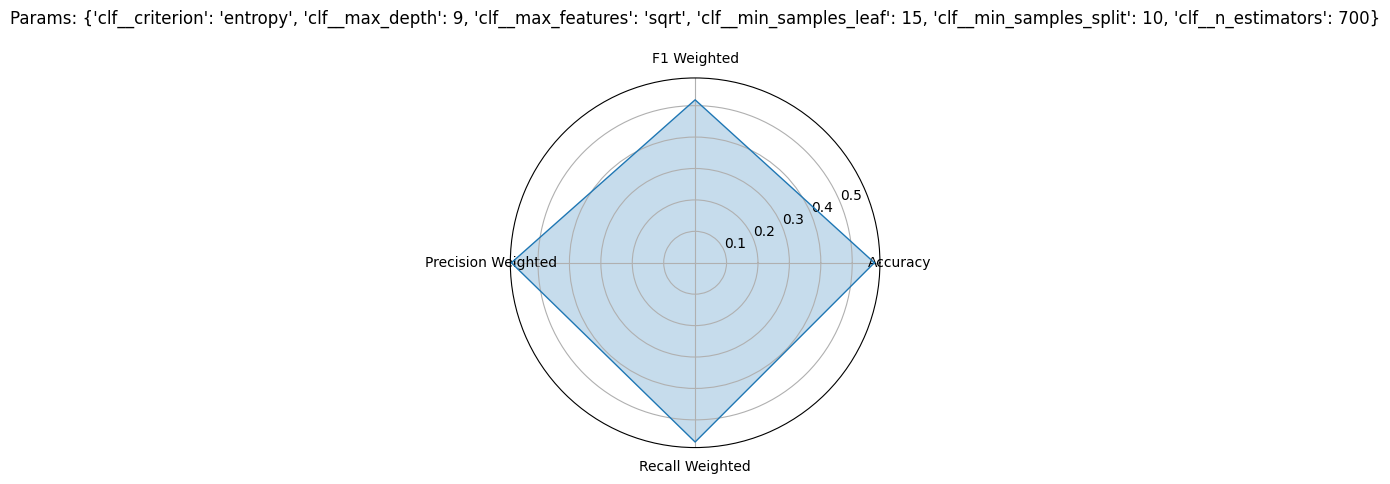

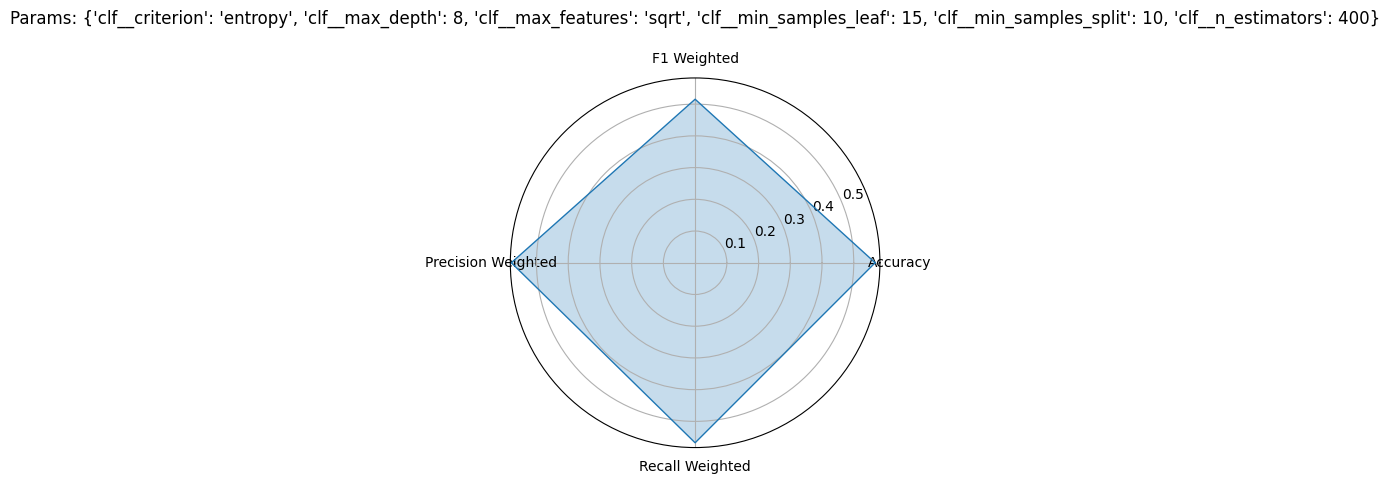

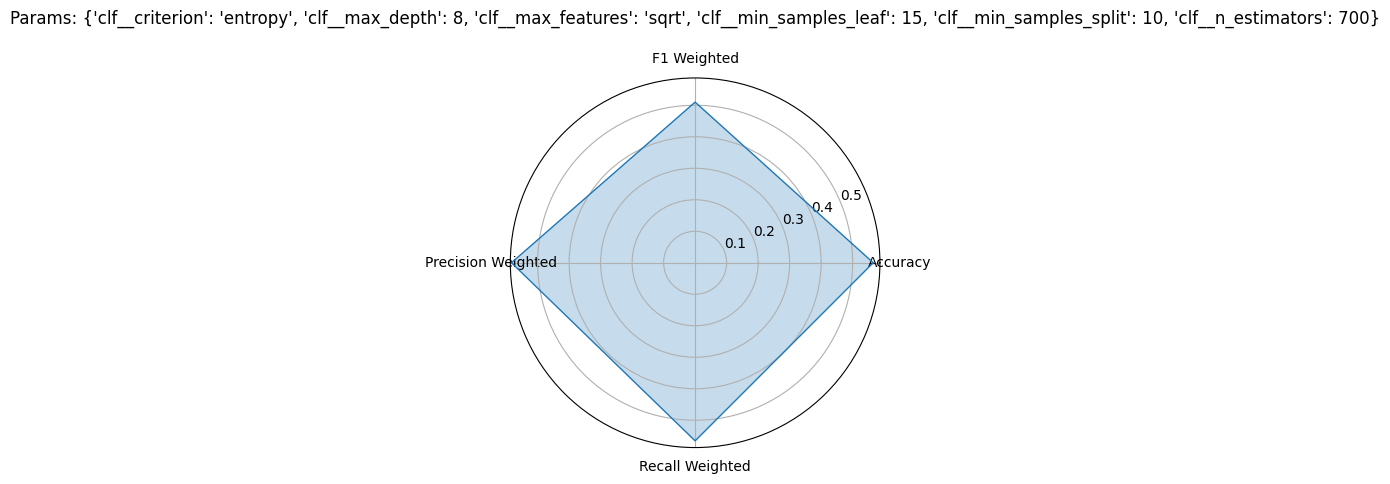

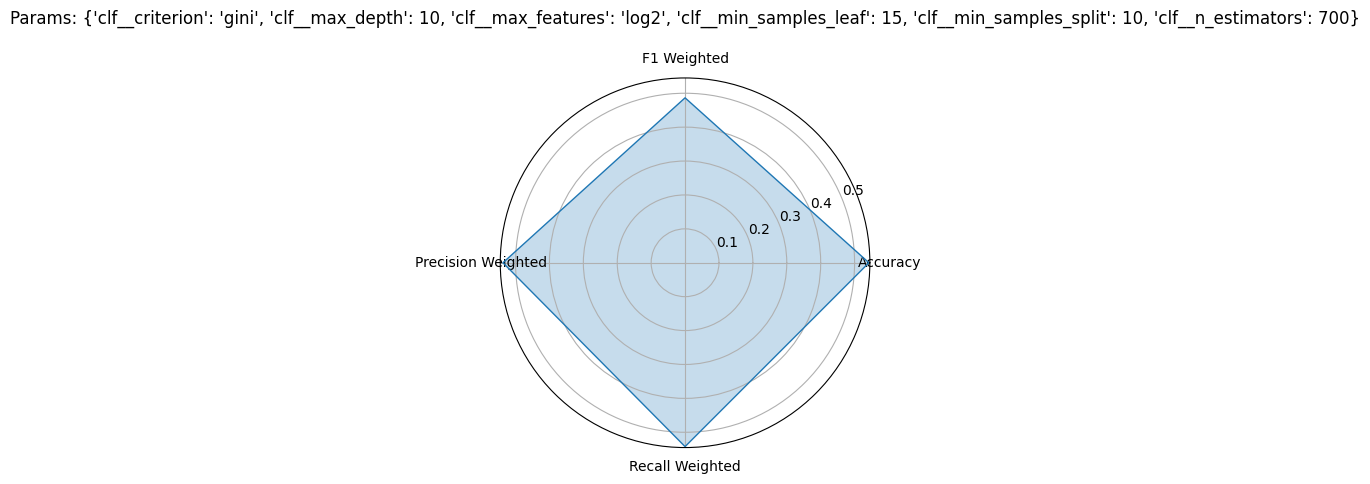

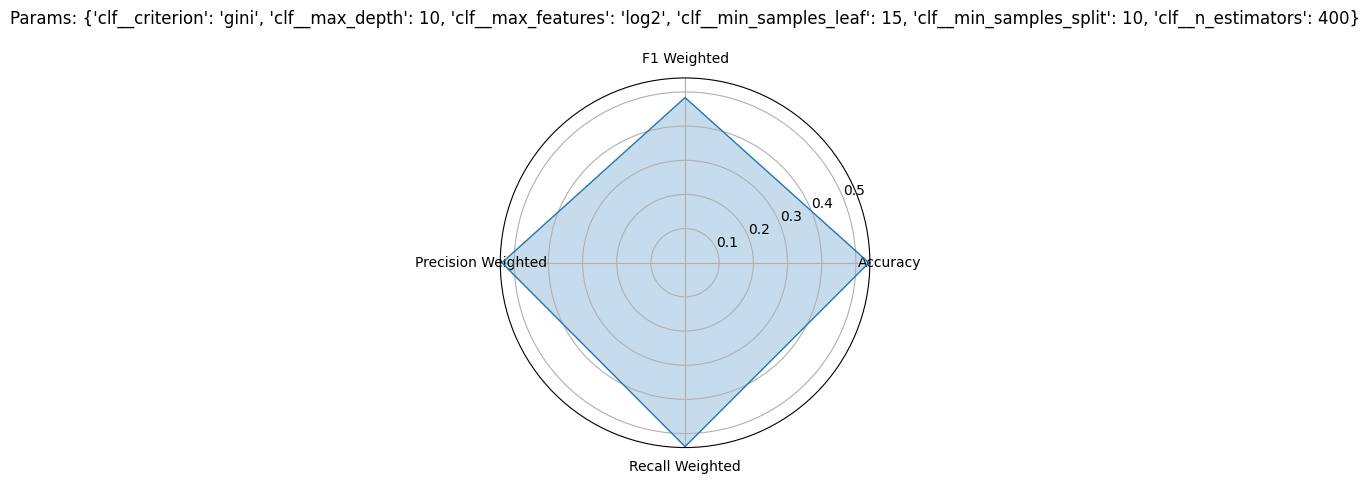

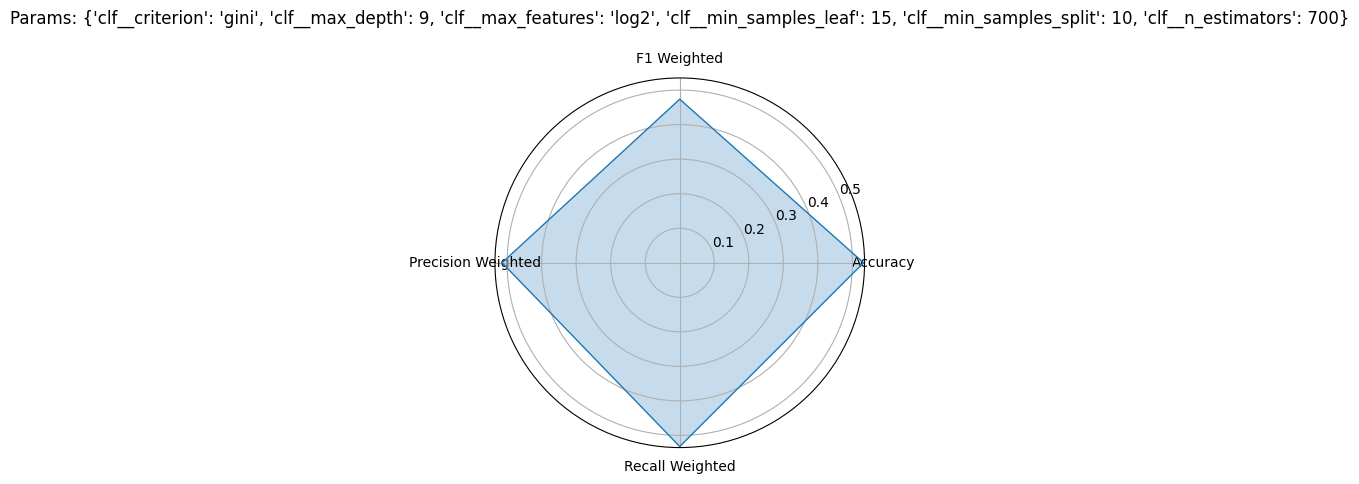

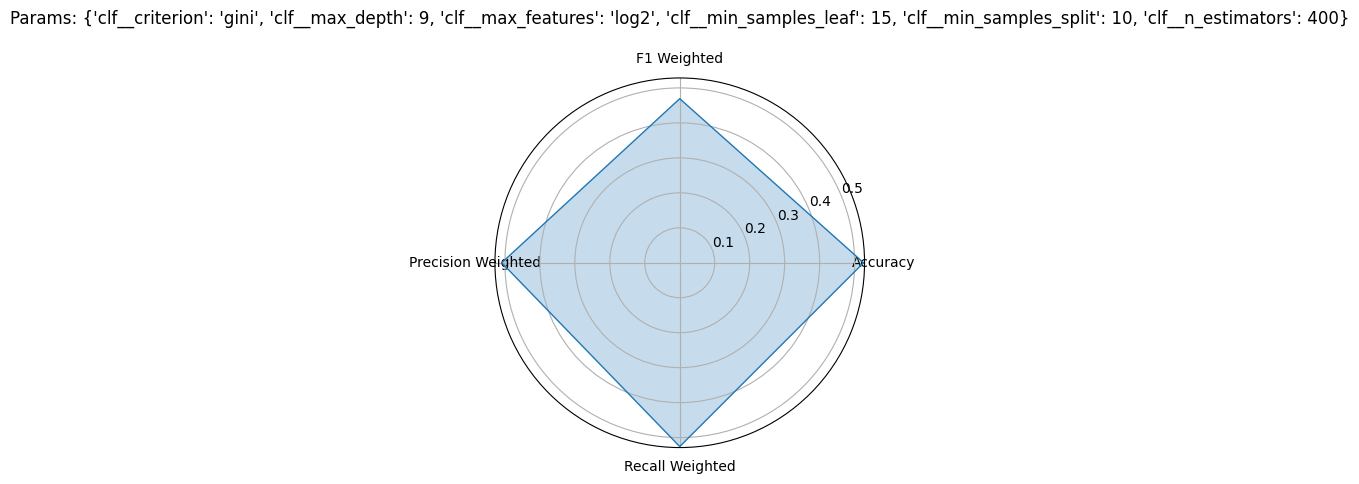

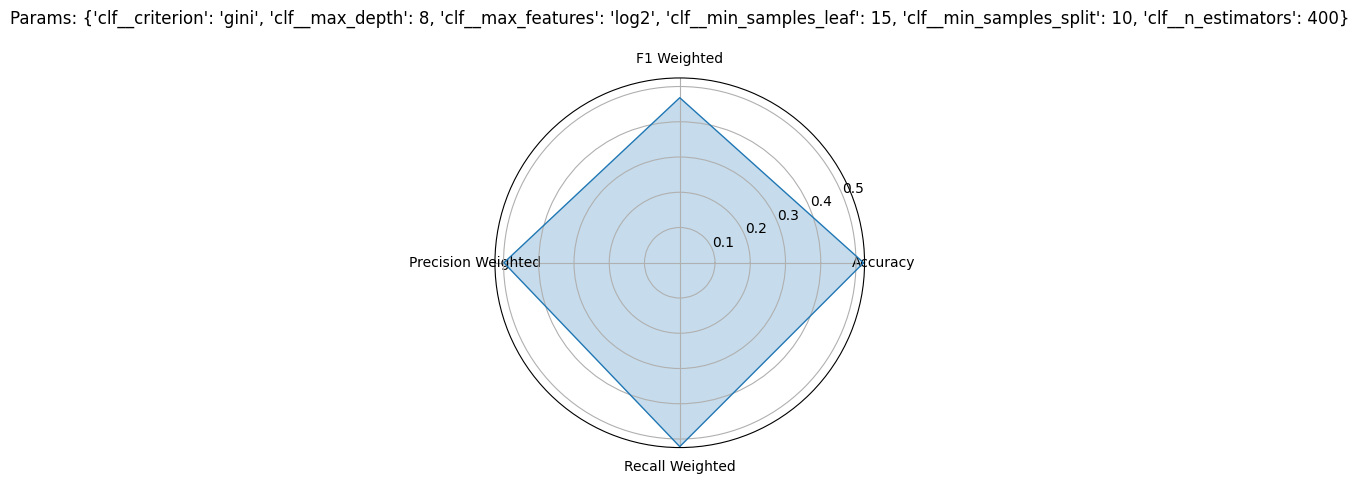

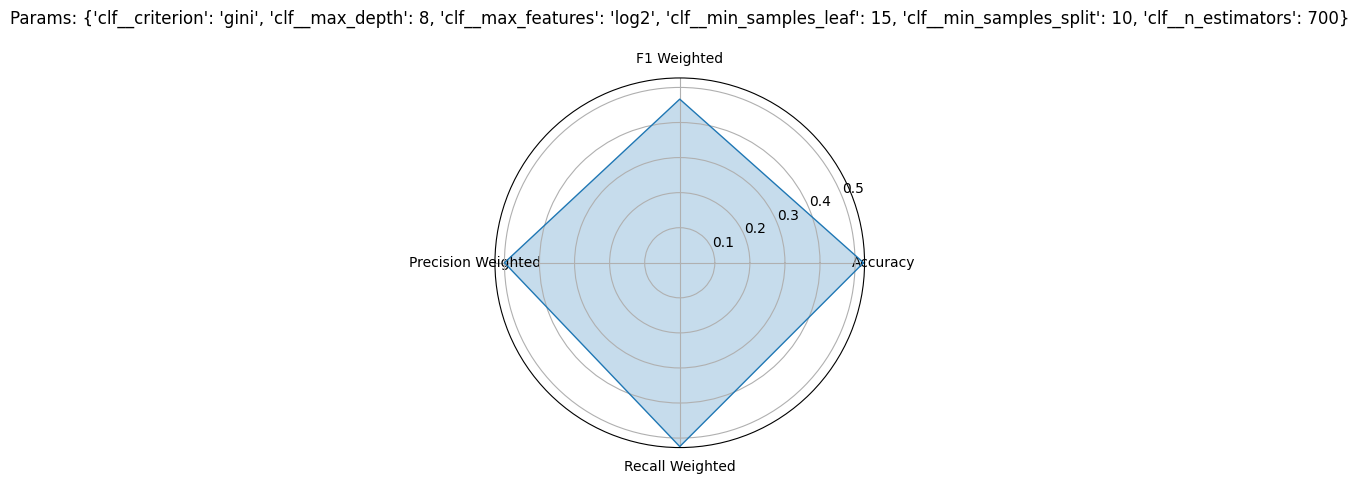

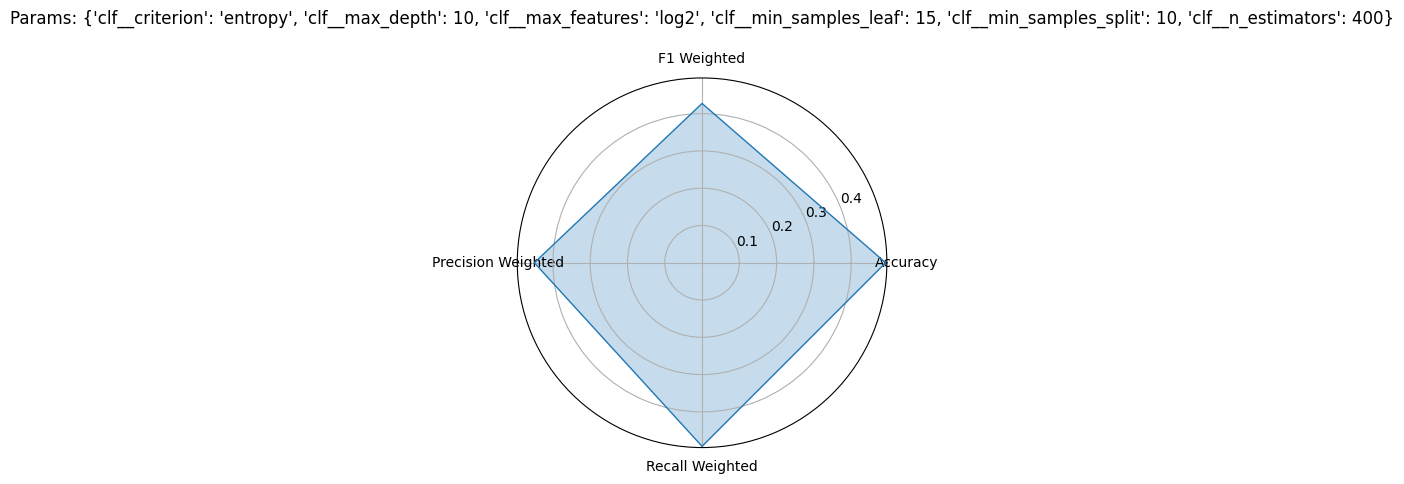

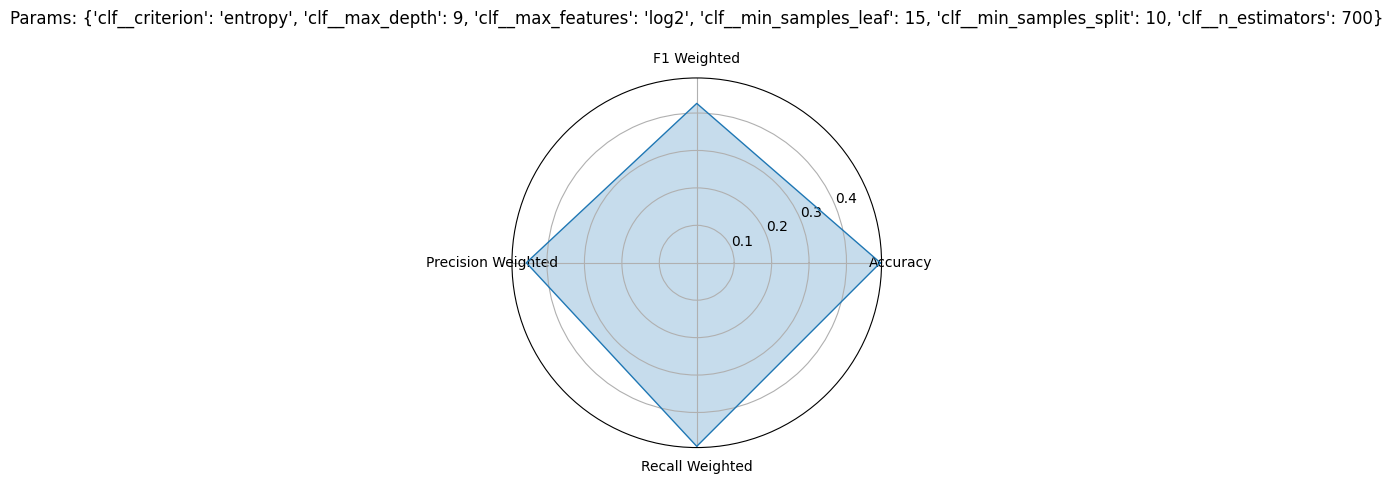

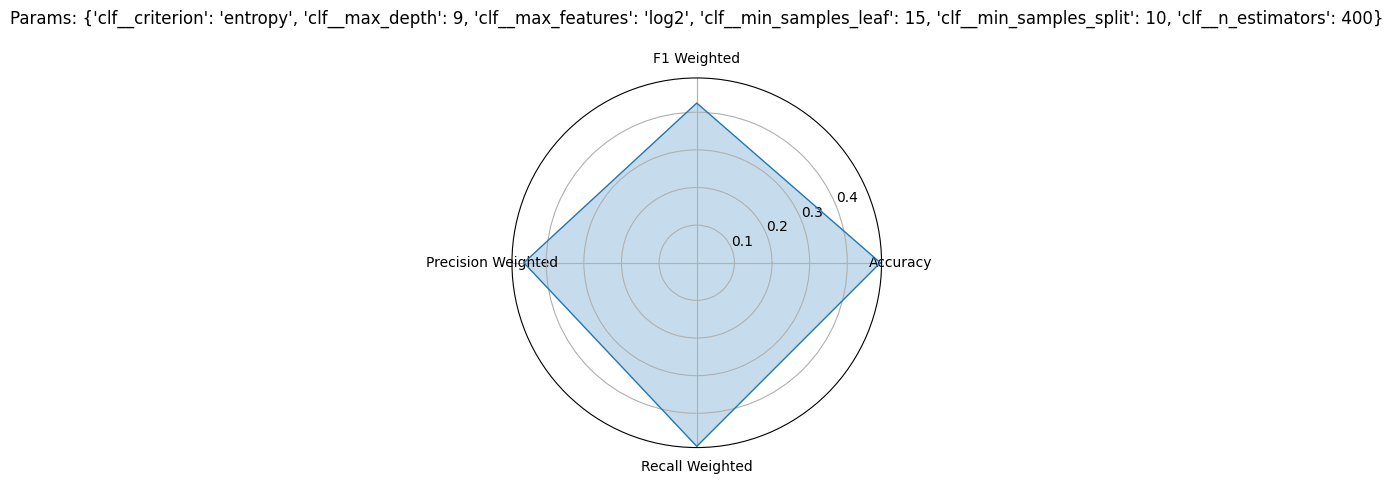

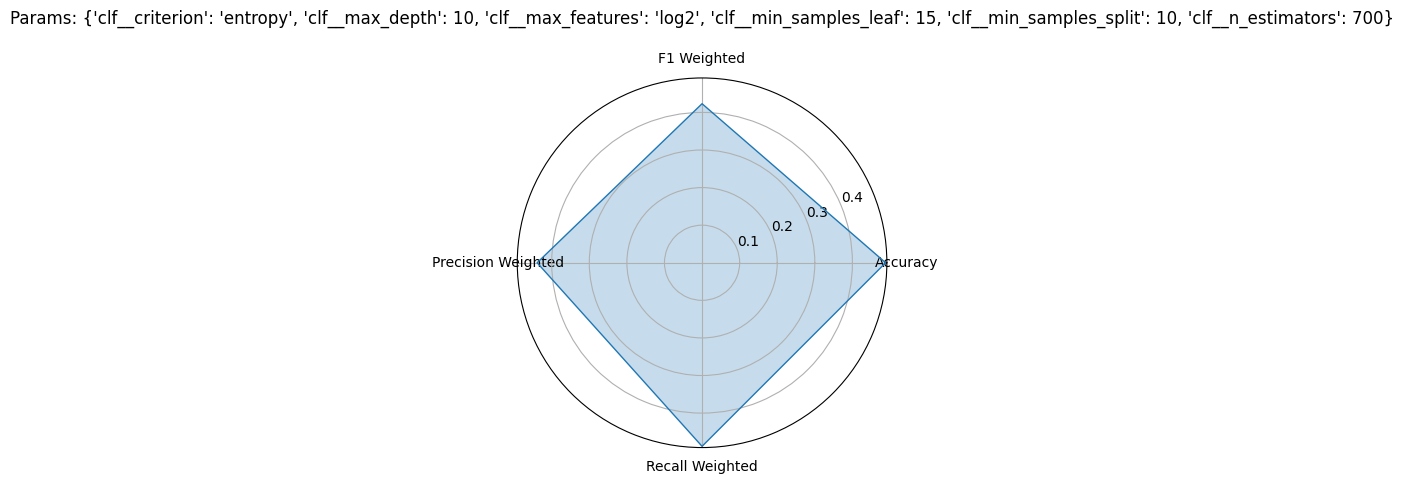

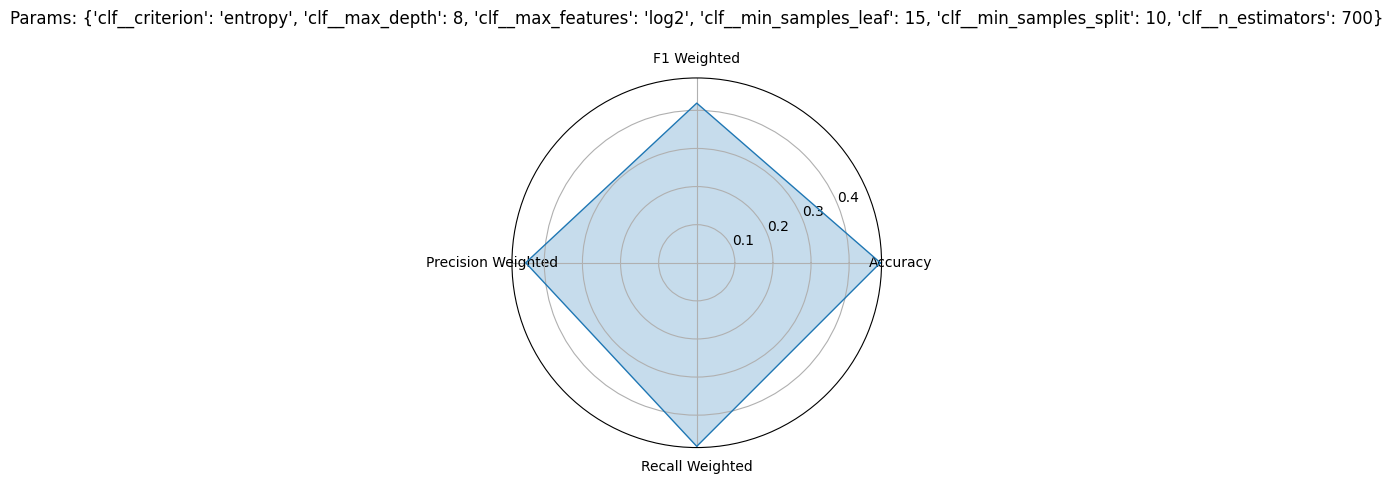

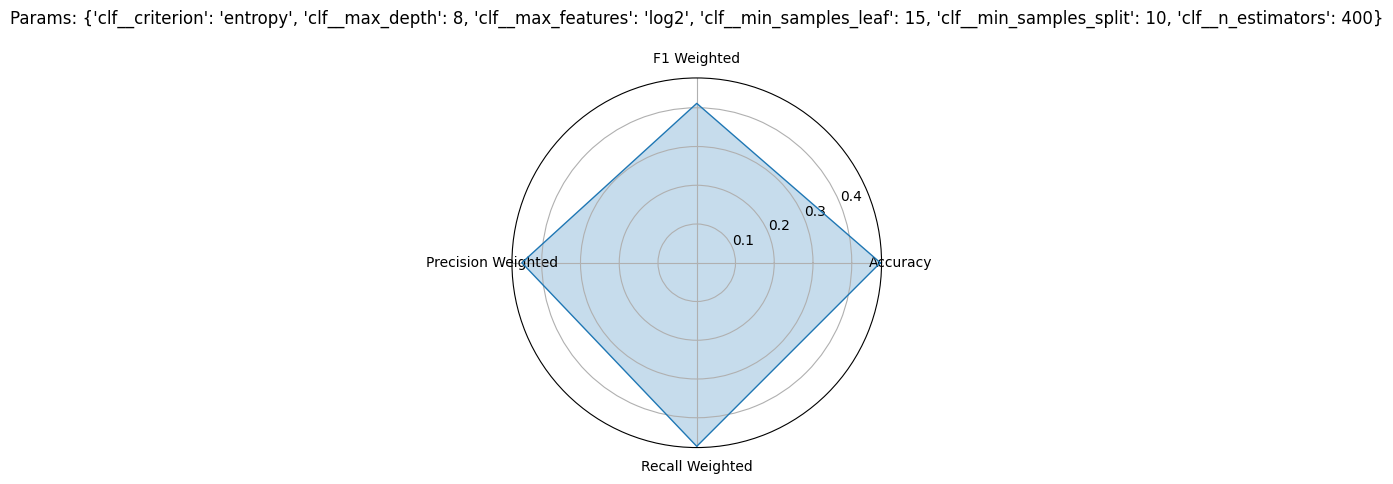

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Definisci le metriche di interesse
metrics = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']

# 2) Calcola gli angoli per il radar chart (chiusura inclusa)
num_metrics = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # ripeti il primo angolo per chiudere il poligono

# 3) Cicla su ogni riga di results_df
for idx, row in results_df.iterrows():
    # Estrai i valori medi di test per ciascuna metrica e chiudi il loop
    values = [row[f'mean_test_{m}'] for m in metrics]
    values += values[:1]

    # 4) Crea una figura e un asse polare
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)

    # 5) Traccia il bordo e riempi
    ax.plot(angles, values, linewidth=1)
    ax.fill(angles, values, alpha=0.25)

    # 6) Imposta le etichette sugli angoli
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics])

    # 7) Titolo con i parametri
    ax.set_title(f"Params: {row['params']}", pad=20)

    # 8) Mostra il grafico
    plt.show()
